##### Mamy co prawda dodatkowe benefity dla naszych najlepszych klientów, ale może dałobysię ustalić kto potencjalnie jest skłonny wydawać u nas więcej?

# Etap 1

1. Definicja problemu biznesowego, zdefiniowanie zadania/zadań modelowania i wszystkich założeń, zaproponowanie kryteriów sukcesu.
2. Analiza danych z perspektywy realizacji tych zadań (trzeba ocenić, czy dostarczone dane są wystarczające – może czegoś brakuje, może coś trzeba poprawić, domagać się innych danych).

#### Kontekst
- sklep internetowy z elektroniką i grami komputerowymi.

#### Zadanie biznesowe
- przewidywanie czy dana sesja klienta zakończy się zakupem po zaoferowaniu mu odpowiedniej zniżki

#### Biznesowe kryterium sukcesu
- Po wdrożeniu systemu oczekujemy, że sprzedaż wzrośnie. Model przewiduje, czy dana sesja skończy się zakupem. Po ponownym uruchomieniu modelu, ale ze zwiększoną zniżką znajdziemy klientów, którzy po zmianie ceny jednak zdecydują się na zakup, dlatego dzięki modelowi więcej osób będzie kupować produkty.

#### Definicja zadania/zadań modelowania

- ##### Zadanie modelowania: 
    klasyfikacja (Logistic Regression i XGBoost)

- ##### Dane do modelowania
    Zbiór danych sesji uzupełnionych o ceny, kategorie produktów oraz miasto zamieszkania usera.
    - users: id, city
    - sessions: session_id, user_id, timestamp, product_id, **event_type, offered_discount**, purchase_id
    - product_id, category_path, **price**
    
Finalna decyzja zakupu może mieć duży związek z interakcją ceny z obniżką. Klient może być bardziej skory do kupna, jeżeli dostanie 10% zniżki na produkt o wartości 1000 zł, niż do kupna produktu z tą samą zniżką, ale o wartości 100 zł. 

- ##### Analityczne kryterium sukcesu
Zbudowanie zbalansowanego modelu, który przewyższa skuteczność modelu naiwnego.

_Model naiwny w naszym przypadku mógłby przewidywać tylko VIEW PRODUCT i miałby wtedy około 85,7% skuteczności (Aktualnie na 6 akcji VIEW PRODUCT, mamy 1 akcję BUY PRODUCT (14.3%))._

#### Założenia
- przewidujemy klasę dla danych wejściowych (event type: VIEW PRODUCT lub BUY PRODUCT)
- parametry analitycznego kryterium sukcesu są ustalone bezpośrednio na podstawie biznesowego kryterium sukcesu.

#### Analiza danych z perspektywy realizacji zadań

Pracujemy na nowych danych, które nie zawierają braków.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os, glob

inputs = []

for each in sorted(glob.glob(os.path.join(os.getcwd(),'./new_data/*.jsonl'), recursive=True)):
    print(f'Name with path: {each} \nName without path: {os.path.basename(each)}')
    inputs.append(each)

Name with path: C:\Users\Aleksandra\Downloads\./new_data\deliveries.jsonl 
Name without path: deliveries.jsonl
Name with path: C:\Users\Aleksandra\Downloads\./new_data\products.jsonl 
Name without path: products.jsonl
Name with path: C:\Users\Aleksandra\Downloads\./new_data\sessions.jsonl 
Name without path: sessions.jsonl
Name with path: C:\Users\Aleksandra\Downloads\./new_data\users.jsonl 
Name without path: users.jsonl


In [3]:
deliveries = pd.read_json(inputs[0], lines=True)
products = pd.read_json(inputs[1], lines=True)
sessions = pd.read_json(inputs[2], lines=True)
users = pd.read_json(inputs[3], lines=True)

USERS

In [4]:
users.count()

user_id    200
name       200
city       200
street     200
dtype: int64

In [5]:
users.sample(3)

,user_id,name,city,street
106,208,Konrad Ciuk,Mielec,aleja Stolarska 439
110,212,Adam Zbroszczyk,Police,al. Akacjowa 77
155,257,Monika Samul,Szczecin,pl. Kasztanowa 25


In [6]:
# nie ma dwóch użytkowników o takich samych imionach i nazwiskach
users.name.nunique()

200

DELIVERIES

In [7]:
deliveries.count()

purchase_id           6339
purchase_timestamp    6339
delivery_timestamp    6339
delivery_company      6339
dtype: int64

In [8]:
deliveries.sample(3)

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
4845,24846,2021-04-01T12:48:53,2021-04-05T12:50:11,516
458,20459,2020-05-01T11:17:17,2020-05-05T11:19:34,516
5050,25051,2021-03-27T21:30:12,2021-04-01T21:31:47,516


In [9]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   purchase_id         6339 non-null   int64 
 1   purchase_timestamp  6339 non-null   object
 2   delivery_timestamp  6339 non-null   object
 3   delivery_company    6339 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 198.2+ KB


In [10]:
pd.DataFrame({'total_missing': deliveries.isnull().sum(), 'perc_missing': (deliveries.isnull().sum()/deliveries.purchase_id.count())*100})

,total_missing,perc_missing
purchase_id,0,0.0
purchase_timestamp,0,0.0
delivery_timestamp,0,0.0
delivery_company,0,0.0


SESSIONS

In [11]:
sessions.describe()

,session_id,user_id,product_id,offered_discount,purchase_id
count,37169.000000,37169.000000,37169.000000,37169.000000,6339.00000
mean,104916.144421,201.799645,1126.983911,4.875434,23170.00000
std,2833.445266,57.784774,118.472731,6.986422,1830.05601
min,100001.000000,102.000000,1001.000000,0.000000,20001.00000
25%,102467.000000,151.000000,1036.000000,0.000000,21585.50000
50%,104891.000000,198.000000,1067.000000,0.000000,23170.00000
75%,107403.000000,252.000000,1278.000000,10.000000,24754.50000
max,109837.000000,301.000000,1319.000000,20.000000,26339.00000


In [12]:
sessions.sample(3)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
31196,108258,2021-03-23 19:15:20,273,1318,VIEW_PRODUCT,0,NaN
2221,100613,2020-05-19 13:49:33,113,1035,BUY_PRODUCT,0,20397.0
25315,106694,2021-04-14 08:13:12,238,1234,VIEW_PRODUCT,0,NaN


In [13]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37169 entries, 0 to 37168
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        37169 non-null  int64         
 1   timestamp         37169 non-null  datetime64[ns]
 2   user_id           37169 non-null  int64         
 3   product_id        37169 non-null  int64         
 4   event_type        37169 non-null  object        
 5   offered_discount  37169 non-null  int64         
 6   purchase_id       6339 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.0+ MB


In [14]:
pd.DataFrame({'total_missing': sessions.isnull().sum(), 'perc_missing': (sessions.isnull().sum()/sessions.session_id.count())*100})

,total_missing,perc_missing
session_id,0,0.000000
timestamp,0,0.000000
user_id,0,0.000000
product_id,0,0.000000
event_type,0,0.000000
offered_discount,0,0.000000
purchase_id,30830,82.945465


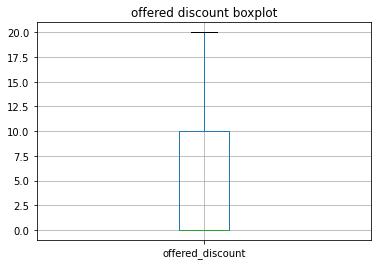

In [15]:
# nie ma żadnych wartości odstających do poprawienia
numerical_columns = ["offered_discount"]
sessions[numerical_columns].boxplot()
plt.title("offered discount boxplot")
plt.show()

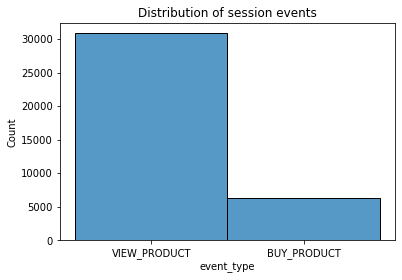

In [16]:
sns.histplot(sessions.event_type)
plt.title("Distribution of session events")
plt.show()

# na 6 oglądań, średnio mamy 1 zakup

In [17]:
# ile brakuje purchase_id gdy typ sesji to BUY_PRODUCT?
sessions[sessions.event_type=="BUY_PRODUCT"].purchase_id.isna().sum()

0

Gdy ktoś kupuje produkt, zawsze znamy id tego produktu.

In [18]:
# ile sesji typu VIEW_PRODUCT ma purchase_id (prawdopodobnie niepotrzebne informacje)?
sessions[sessions.event_type=="VIEW_PRODUCT"].purchase_id.notna().sum()

0

PRODUCTS

In [19]:
# brak pustych komóre
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


In [20]:
products.sample(3)

,product_id,product_name,category_path,price
111,1112,Singularity (PC),Gry i konsole;Gry komputerowe,8.9
271,1272,The Ball (PC),Gry i konsole;Gry komputerowe,1.0
229,1230,Symulator Robót Drogowych (PC),Gry i konsole;Gry komputerowe,47.7


In [21]:
products.describe()

,product_id,price
count,319.000000,319.000000
mean,1160.000000,247.787962
std,92.231593,813.788548
min,1001.000000,1.000000
25%,1080.500000,24.990000
50%,1160.000000,41.000000
75%,1239.500000,92.995000
max,1319.000000,7639.000000


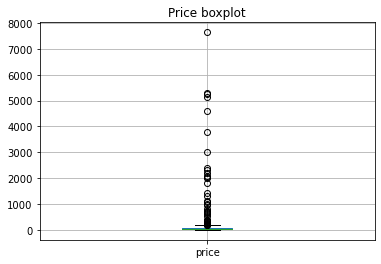

In [22]:
numerical_columns = ['price']
products[numerical_columns].boxplot()
plt.title('Price boxplot')
plt.show()

In [23]:
products[products['price'] == 1]

,product_id,product_name,category_path,price
140,1141,Król Futbolu Piłkarski Quiz (PC),Gry i konsole;Gry komputerowe,1.0
192,1193,Heroes Over Europe (PC),Gry i konsole;Gry komputerowe,1.0
271,1272,The Ball (PC),Gry i konsole;Gry komputerowe,1.0


In [24]:
# ceny niedodatnie
products[products['price'] <= 0].count()

product_id       0
product_name     0
category_path    0
price            0
dtype: int64

In [25]:
# merge sessions with products
shop_df = sessions.merge(products, on="product_id", how="left")

In [26]:
# merge sessions and products with users
shop_df = shop_df.merge(users, on='user_id', how = 'left')

In [27]:
shop_df.sample(3)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price,name,city,street
9255,102459,2021-03-15 23:23:47,151,1293,VIEW_PRODUCT,0,NaN,Hama 44292,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,44.99,Dawid Rzeźniczak,Radom,pl. Lawendowa 338
16737,104385,2021-03-31 17:07:58,190,1318,BUY_PRODUCT,0,22857.0,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,553.00,Justyna Karwala,Police,al. Torowa 460
3062,100849,2021-04-16 07:21:03,120,1009,VIEW_PRODUCT,0,NaN,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69.00,Olaf Szymula,Warszawa,plac Browarna 72


In [28]:
shop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37169 entries, 0 to 37168
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        37169 non-null  int64         
 1   timestamp         37169 non-null  datetime64[ns]
 2   user_id           37169 non-null  int64         
 3   product_id        37169 non-null  int64         
 4   event_type        37169 non-null  object        
 5   offered_discount  37169 non-null  int64         
 6   purchase_id       6339 non-null   float64       
 7   product_name      37169 non-null  object        
 8   category_path     37169 non-null  object        
 9   price             37169 non-null  float64       
 10  name              37169 non-null  object        
 11  city              37169 non-null  object        
 12  street            37169 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 4.0+ MB


Zmienną celu jest event_type_BUY_PRODUCT. Sprawdzamy współczynnik wzajemnej informacji między tą zmienną i innymi atrybutami. 

Pomijamy atrybut purchase_id, ponieważ jest on znany tylko wtedy, gdy dokonano zakupu. Dodajemy kolumnę 'purchase_id_nan', której wartości to 1, gdy nie dokonano zakupu i 0, jeśli dokonano. 

Do analizy używamy one hot encoding (pd.get_dummies()) i dlatego pomijamy też kolumny 'name' oraz 'street'. Możemy to ominąć, ponieważ mamy kolumnę 'user_id', która mówi nam o tym, który to użytkownik. Z tego samego powodu pomijamy 'product_name' - mamy 'product_id' i to wystarczy.

In [29]:
shop_df["purchase_id_isnan"] = np.where(shop_df.purchase_id.isnull(), 1, 0)

# dodajemy nowy atrubut: price*offered_discount
shop_df["discount_price"] = (shop_df["price"] * shop_df["offered_discount"])

# dataframe tylko dla XGB
shop_df_xgb = shop_df.copy()

shop_df = shop_df[shop_df.columns[~shop_df.columns.isin(["product_name", "purchase_id", "name", "street"])]]
shop_df = pd.get_dummies(shop_df)

## Sprawdzenie współczynnika wzajemnej informacji

In [30]:
shop_df_check = shop_df.copy()
shop_df_check.sample(3)

,session_id,timestamp,user_id,product_id,offered_discount,price,purchase_id_isnan,discount_price,event_type_BUY_PRODUCT,event_type_VIEW_PRODUCT,...,category_path_Telefony i akcesoria;Telefony komórkowe,category_path_Telefony i akcesoria;Telefony stacjonarne,city_Gdynia,city_Konin,city_Kutno,city_Mielec,city_Police,city_Radom,city_Szczecin,city_Warszawa
21848,105746,2021-01-30 05:59:22,217,1042,15,129.00,1,1935.00,0,1,...,0,0,0,0,1,0,0,0,0,0
25571,106757,2021-04-13 16:21:51,239,1051,0,76.90,0,0.00,1,0,...,0,0,0,0,1,0,0,0,0,0
34258,109079,2021-04-08 12:40:42,286,1001,5,58.97,0,294.85,1,0,...,0,1,0,1,0,0,0,0,0,0


In [31]:
shop_df_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37169 entries, 0 to 37168
Data columns (total 33 columns):
 #   Column                                                                           Non-Null Count  Dtype         
---  ------                                                                           --------------  -----         
 0   session_id                                                                       37169 non-null  int64         
 1   timestamp                                                                        37169 non-null  datetime64[ns]
 2   user_id                                                                          37169 non-null  int64         
 3   product_id                                                                       37169 non-null  int64         
 4   offered_discount                                                                 37169 non-null  int64         
 5   price                                                              

Sprawdzamy współczynnik wzajemnej informacji między zmienną celu, a innymi atrybutami. Aby sprawdzić, czy współczynnik jest wysoki, permutujemy każdą z kolumn tworząc szum i porównujemy wyniki wzajemnej informacji z szumem i z oryginalnym atrybutem.

In [32]:
y = shop_df_check["event_type_BUY_PRODUCT"]
shop_df_check = shop_df_check[shop_df_check.columns[~shop_df_check.columns.isin(["event_type_BUY_PRODUCT", "event_type_VIEW_PRODUCT", "purchase_id_isnan", "timestamp"])]]

cols = shop_df_check.columns
mutual_info_scores = {}
mutual_info_noise_scores = {}

shop_np_check = shop_df_check.to_numpy()
shop_np_check_with_noise = shop_df_check.copy().to_numpy()

mutual_info_scores = mutual_info_classif(shop_np_check, y)

# permutacja kolumn w shop_np_check_with_noise
np.random.seed(42)
np.random.shuffle(np.transpose(shop_np_check_with_noise))
mutual_info_noise_scores = mutual_info_classif(shop_np_check_with_noise, y)

In [33]:
mi_df = pd.DataFrame([mutual_info_scores, mutual_info_noise_scores], index=["mutual_info_score", "noise"]).T
mi_df.index = shop_df_check.columns
mi_df

,mutual_info_score,noise
session_id,0.000000,0.001287
user_id,0.005199,0.008078
product_id,0.025453,0.005118
offered_discount,0.001802,0.000000
price,0.025678,0.004585
discount_price,0.008356,0.000000
category_path_Gry i konsole;Gry komputerowe,0.003962,0.000000
category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,0.002843,0.000000
category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,0.002010,0.000000
category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,0.001908,0.000000


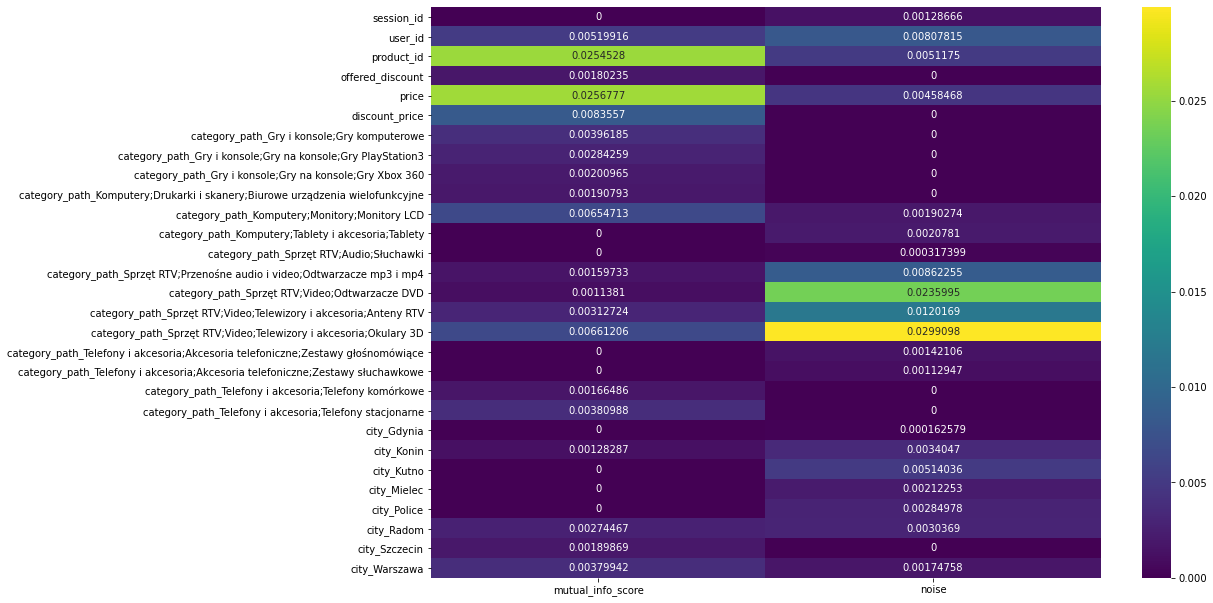

In [34]:
plt.figure(figsize=(15,10.5))
sns.heatmap(mi_df, annot=True, fmt="g", cmap='viridis')

plt.show()

Wybieramy kolumny, których współczynnik wzajemnej informacji z funkcją celu jest większy, niż funkcji celu z szumem.

In [35]:
useful_categories = np.where(mutual_info_scores > mutual_info_noise_scores, 1, 0)
useful_categories_indices = np.argwhere(useful_categories == np.amax(useful_categories))

In [36]:
print("Meaningful categories are: \n", shop_df_check.columns[useful_categories_indices])

Meaningful categories are: 
 [['product_id']
 ['offered_discount']
 ['price']
 ['discount_price']
 ['category_path_Gry i konsole;Gry komputerowe']
 ['category_path_Gry i konsole;Gry na konsole;Gry PlayStation3']
 ['category_path_Gry i konsole;Gry na konsole;Gry Xbox 360']
 ['category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne']
 ['category_path_Komputery;Monitory;Monitory LCD']
 ['category_path_Telefony i akcesoria;Telefony komórkowe']
 ['category_path_Telefony i akcesoria;Telefony stacjonarne']
 ['city_Szczecin']
 ['city_Warszawa']]


# Etap 2

1. Dwa modele: model bazowy (najprostszy możliwy dla danego zadania) i bardziej zaawansowany model docelowy, oraz raport pokazujący proces budowy modelu i porównujący wyniki (0-15pkt).
2. Implementacja aplikacji (w formie mikroserwisu), która pozwala na (0-15pkt):
    - serwowanie predykcji przy pomocy danego modelu,
    - realizację eksperymentu A/B –w ramach którego porównywane będą oba modelei zbierane dane niezbędne do późniejszej oceny ich jakości,
    - materiały pokazujące, że implementacja działa.

Od początku zdawaliśmy sobie sprawę, że nasz dataset jest bardzo niezbalansowany, co przedstawia poniższy wykres.

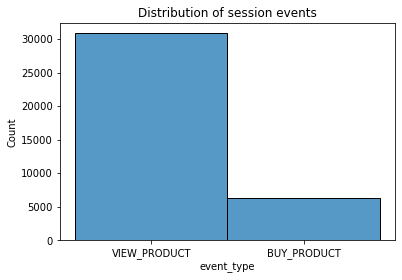

In [37]:
sns.histplot(sessions.event_type)
plt.title("Distribution of session events")
plt.show()

Oba nasze pierwsze modele z Logistic Regression i XGBoost nie biorą tego pod uwagę. Pomimo, że ich dokładność jest bardzo wysoka, to po spojrzeniu w macierz korelacji zauważamy, że przewidują one prawie zawsze tylko brak zakupu i finalnie nie przewyższają skuteczności modelu naiwnego.

## Logistic Regression

In [38]:
y_col = 'event_type_BUY_PRODUCT'

In [39]:
X_train, X_test, y_train, y_test = train_test_split(shop_df[shop_df.columns[useful_categories_indices].flatten()], shop_df[y_col], test_size=0.2, random_state=42)

### Niezbalansowany model

In [40]:
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [41]:
model.score(X_train, y_train)

1.0

In [42]:
model.score(X_test, y_test)

1.0

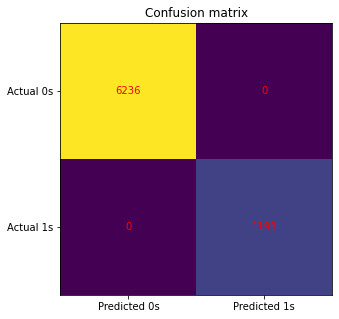

In [43]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

### Zbalansowany model

In [44]:
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0, class_weight='balanced').fit(X_train, y_train)
y_pred = model.predict(X_test)

In [45]:
model.score(X_train, y_train)

1.0

In [46]:
model.score(X_test, y_test)

1.0

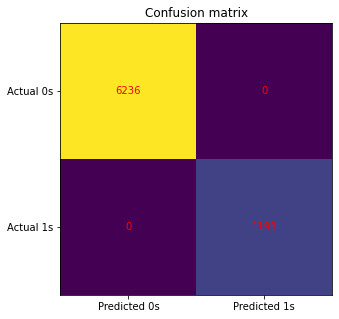

In [47]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

## XGBoost

In [48]:
from xgboost import XGBClassifier

In [49]:
X_col = shop_df_check.columns
X_train, X_test, y_train, y_test = train_test_split(shop_df[X_col], shop_df[y_col], test_size=0.2, random_state=42)

### Niezbalansowany model

In [50]:
model = XGBClassifier()
model.fit(X_train, y_train)

cols_when_model_builds = model.get_booster().feature_names
X_test = X_test[cols_when_model_builds]

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy_score(y_test, predictions)

[17:14:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8239171374764596

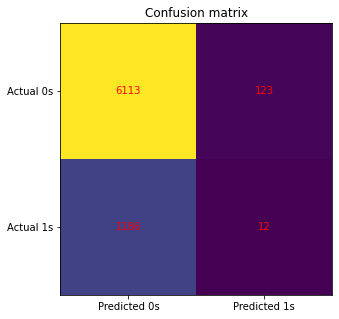

In [51]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

### Zbalansowany model

In [52]:
model = XGBClassifier(scale_pos_weight=5)
model.fit(X_train, y_train)

cols_when_model_builds = model.get_booster().feature_names
X_test = X_test[cols_when_model_builds]

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy_score(y_test, predictions)

[17:14:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6416464891041163

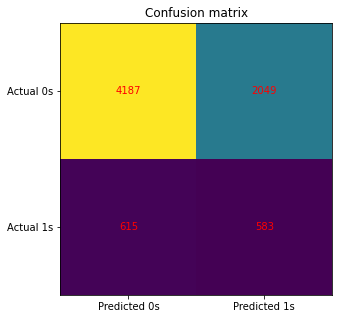

In [53]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

### GridSearchCV do znalezienia odpowiedniej wagi do XGBoost

In [54]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define grid
weights = [1, 2, 4, 8, 10, 25, 50]
param_grid = dict(scale_pos_weight=weights)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)

[17:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [55]:
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.604133 using {'scale_pos_weight': 1}
0.604133 (0.007212) with: {'scale_pos_weight': 1}
0.597436 (0.005888) with: {'scale_pos_weight': 2}
0.591857 (0.006603) with: {'scale_pos_weight': 4}
0.584545 (0.006868) with: {'scale_pos_weight': 8}
0.579426 (0.008110) with: {'scale_pos_weight': 10}
0.574563 (0.006877) with: {'scale_pos_weight': 25}
0.571209 (0.008181) with: {'scale_pos_weight': 50}
